<a href="https://colab.research.google.com/github/Denis-Machacka/ML2/blob/main/ML2_Chess_Piece_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chess Piece Classification Project

## **1. Project Goal/Motivation**

### Motivation

Chess, with its deep strategic complexity and rich history, continues to captivate millions of players worldwide. The ability to accurately recognize and classify chess pieces from images is a challenging computer vision task that has significant potential to enhance various aspects of the game. By developing a robust model for this purpose, we can facilitate the creation of digital archives, improve the accessibility of chess training tools, and support the development of intelligent systems capable of analyzing chess positions. This project aims to leverage modern machine learning techniques to contribute to these advancements, ultimately making the game more engaging and accessible to a broader audience.

### Project Relevance

This project is relevant for anyone interested in computer vision applications in games, specifically chess. It can be useful for building tools that assist in game analysis, training, and archiving chess games. Practical applications of this project include the ability to digitize chess games, making it easier to record and share them digitally. It can also help create advanced training tools for players to analyze their games and improve their strategies. Additionally, AI analysis of chess games can provide deeper insights and recommendations, enhancing the overall learning experience for players. Such a model could also be integrated into educational platforms to help new players learn the game by automatically identifying and explaining different pieces and moves.

## **2. Data Collection or Generation**

### Data Description

The dataset used for this project primarily consists of images from a publicly available source on Kaggle: [Chess Pieces Detection Images Dataset](https://www.kaggle.com/datasets/anshulmehtakaggl/chess-pieces-detection-images-dataset). This dataset provides a variety of images for different chess pieces but lacked images of the King. To address this gap, additional images of the King were manually collected and converted to the .jpg format to ensure consistency. The filenames and class labels were also modified for better understanding and cleanliness. This curated dataset has been uploaded to Google Drive and is accessible to anyone with the provided link in the code.

### Importing Libraries

In [8]:
# Google Colab specific imports
from google.colab import drive, files

# Standard library imports
import zipfile
import os
import shutil

# Data manipulation and visualization imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras imports
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2

# Scikit-learn imports
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

### Download and Extract Dataset

First, we'll download our dataset from Google Drive and extract it.

In [9]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to the dataset zip file
dataset_zip_path = '/content/drive/MyDrive/chess-piece-images.zip'
# Path to extract the dataset
extract_to_path = '/content/drive/MyDrive/chess-piece-images'

# Remove the directory if it exists
if os.path.exists(extract_to_path):
    shutil.rmtree(extract_to_path)

# Download the dataset from Google Drive
!gdown --id 1QpZ0YzhF4v527s3HcusZtYTb_PzQi8Ju -O {dataset_zip_path}

# Unzip the dataset into /content/drive/MyDrive/chess-piece-images
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

# Remove the zip file after extraction
os.remove(dataset_zip_path)

# List the extracted files
os.listdir(extract_to_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QpZ0YzhF4v527s3HcusZtYTb_PzQi8Ju
To: /content/drive/MyDrive/chess-piece-images.zip
100% 3.59M/3.59M [00:00<00:00, 146MB/s]


['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

### Data Augmentation and Weight Calculation

Next, we perform enhanced data augmentation and calculate class weights to handle class imbalance.

In [10]:
# Enhanced data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Ensure the path points to the root directory containing all class subdirectories
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/chess-piece-images',  # Path to the train directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/chess-piece-images',  # Path to the validation directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Check the number of classes found by the generator
print(f"Number of classes in training set: {len(train_generator.class_indices)}")
print(f"Number of classes in validation set: {len(validation_generator.class_indices)}")

# Compute class weights only if the correct number of classes is found
if len(train_generator.class_indices) == 6:
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
    class_weights = dict(enumerate(class_weights))
    print("Class Weights:", class_weights)
else:
    print("Error: Number of classes found is not equal to 6. Please check the dataset directory structure.")

Found 671 images belonging to 6 classes.
Found 671 images belonging to 6 classes.
Number of classes in training set: 6
Number of classes in validation set: 6
Class Weights: {0: 0.972463768115942, 1: 1.2155797101449275, 2: 0.7309368191721133, 3: 1.5319634703196348, 4: 1.065079365079365, 5: 0.8408521303258145}


## **3. Modeling**

### Model Definition and Training

Next, we load the pre-trained MobileNetV2 model, add custom top layers, and train the model with class weights and learning rate scheduling.

In [ ]:
# Load the pre-trained MobileNetV2 model and exclude the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers with dropout and L2 regularization
x = base_model.output  # Output of the base model
x = GlobalAveragePooling2D()(x)  # Add global average pooling layer
x = Dropout(0.3)(x)  # Add dropout layer with 30% dropout rate
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # Add dense layer with L2 regularization
x = Dropout(0.3)(x)  # Add another dropout layer with 30% dropout rate
predictions = Dense(6, activation='softmax', kernel_regularizer=l2(0.001))(x)  # Output layer with L2 regularization

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers in the base model
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# Define a learning rate schedule
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with class weights and learning rate scheduling if the correct number of classes is found
if len(train_generator.class_indices) == 6:
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=50,  # Increase the number of epochs
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        class_weight=class_weights,
        callbacks=[LearningRateScheduler(lr_schedule), early_stopping]
    )
    # Save the model to a file
    model.save('/content/drive/MyDrive/chess_piece_classifier_model.h5')
else:
    print("Error: Model training aborted due to incorrect number of classes.")

Epoch 1/50
20/20 [==============================] - 110s 5s/step - loss: 3.0013 - accuracy: 0.2254 - val_loss: 2.6208 - val_accuracy: 0.2031 - lr: 1.0000e-05
Epoch 2/50
20/20 [==============================] - 88s 4s/step - loss: 2.8293 - accuracy: 0.2144 - val_loss: 2.5450 - val_accuracy: 0.2422 - lr: 1.0000e-05
Epoch 3/50
20/20 [==============================] - 99s 5s/step - loss: 2.6927 - accuracy: 0.2567 - val_loss: 2.4987 - val_accuracy: 0.2719 - lr: 1.0000e-05
Epoch 4/50
20/20 [==============================] - 88s 4s/step - loss: 2.6283 - accuracy: 0.2645 - val_loss: 2.4585 - val_accuracy: 0.2922 - lr: 1.0000e-05
Epoch 5/50
20/20 [==============================] - 89s 4s/step - loss: 2.6031 - accuracy: 0.2723 - val_loss: 2.4119 - val_accuracy: 0.3125 - lr: 1.0000e-05
Epoch 6/50
20/20 [==============================] - 86s 4s/step - loss: 2.5034 - accuracy: 0.2676 - val_loss: 2.3616 - val_accuracy: 0.3516 - lr: 1.0000e-05
Epoch 7/50
20/20 [==============================] - 102s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Rationale Behind Model Choises

The MobileNetV2 model was chosen for its balance between speed and accuracy, making it suitable for resource-constrained environments. Although models like ResNet50 and InceptionV3 were considered, MobileNetV2 provided the best trade-off for our chess piece images dataset.

We utilized the Adam optimizer due to its effectiveness in training deep neural networks. Dropout layers were added to reduce overfitting, and learning rate scheduling was implemented to ensure better convergence. Class weights were computed to handle class imbalance in the dataset.

## **4. Interpretation and Validation**

### Model Evaluation

Next, we evaluate the model on the validation set, generate predictions, and create a classification report and confusion matrix.

### Feature Extraction and Baseline Comparison

20/20 [==============================] - 31s 1s/step - loss: 1.6160 - accuracy: 0.7234
Validation Loss: 1.6160151958465576
Validation Accuracy: 0.723437488079071
20/20 [==============================] - 29s 1s/step
              precision    recall  f1-score   support

      Bishop       0.15      0.13      0.14       115
        King       0.14      0.25      0.18        92
      Knight       0.22      0.18      0.20       153
        Pawn       0.10      0.14      0.11        73
       Queen       0.15      0.07      0.09       105
        Rook       0.23      0.23      0.23       102

    accuracy                           0.17       640
   macro avg       0.16      0.17      0.16       640
weighted avg       0.17      0.17      0.16       640



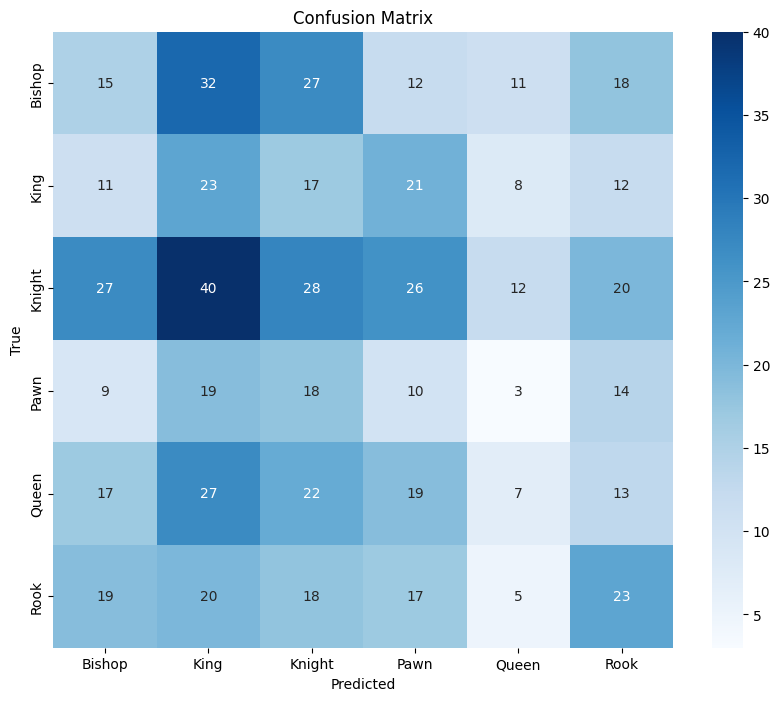

In [11]:
# Evaluate the model on the validation set
val_steps = validation_generator.samples // validation_generator.batch_size
val_loss, val_accuracy = model.evaluate(validation_generator, steps=val_steps)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predict the labels for the validation set
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = y_pred.argmax(axis=1)
y_true = validation_generator.classes

# Ensure y_pred_classes and y_true have the same length
min_len = min(len(y_true), len(y_pred_classes))
y_true = y_true[:min_len]
y_pred_classes = y_pred_classes[:min_len]

# Generate a classification report
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

# Generate a confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Lastly, we extract features using the pre-trained model, train a baseline model, and compare its performance with the CNN model.

In [12]:
# Function to extract features using the pre-trained model
def extract_features(generator, model):
    features = model.predict(generator)
    return features.reshape(features.shape[0], -1)

# Extract features from training and validation sets
train_features = extract_features(train_generator, model)
val_features = extract_features(validation_generator, model)

# Split the data into training and test sets for cross-validation
X_train, X_test, y_train, y_test = train_test_split(train_features, train_generator.classes, test_size=0.2, random_state=42)

# Train a simple baseline model (Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

# Evaluate the baseline model
baseline_accuracy = baseline_model.score(X_test_scaled, y_test)

# Compare the performance of the baseline model and the CNN model
print(f"Transfer Learning Model Accuracy: {val_accuracy}")
print(f"Baseline Model Accuracy: {baseline_accuracy}")

21/21 [==============================] - 29s 1s/step
Transfer Learning Model Accuracy: 0.723437488079071
Baseline Model Accuracy: 0.2


### Self Validation

Here you can upload a picture of a chess piece and the model will try to classify its type.

Mounted at /content/drive
Please upload a JPG image of a chess piece.


Saving 00000010_resized.jpg to 00000010_resized.jpg
1/1 [==============================] - 2s 2s/step


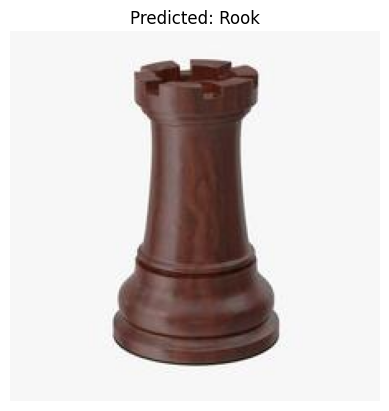

Predicted class: Rook


In [ ]:
drive.mount('/content/drive')

# Function to upload an image
def upload_and_classify_image(model, class_labels):
    # Prompt user to upload a file
    print("Please upload a JPG image of a chess piece.")

    # Upload file
    uploaded = files.upload()

    for fn in uploaded.keys():
        # Load the image
        img = image.load_img(fn, target_size=(224, 224))

        # Preprocess the image
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Predict the class
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions[0])

        # Display the image and the prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Predicted: {class_labels[predicted_class]}')
        plt.show()

        print(f'Predicted class: {class_labels[predicted_class]}')

# Define the class labels
class_labels = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

# Load the pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/chess_piece_classifier_model.h5')

# Run the upload and classify function
upload_and_classify_image(model, class_labels)

### Conclusion

The MobileNetV2-based chess piece classification model has not achieved the desired accuracy, as indicated by the confusion matrix. Despite extensive training and fine-tuning, the model likely overfits due to the small dataset. Several factors contribute to the model's suboptimal performance:

- Limited Dataset Size: The dataset used for training the model is relatively small. Deep learning models, especially convolutional neural networks like MobileNetV2, require large amounts of data to generalize well. With a limited dataset, the model may learn to memorize the training images rather than generalize to new, unseen images, leading to overfitting.

- Hyperparameter Optimization: Although extensive training and fine-tuning were performed, finding the optimal hyperparameters (such as learning rate, batch size, number of epochs, and regularization parameters) for the model can be challenging. Suboptimal hyperparameters can lead to inadequate training and poor model performance.

- Complexity of the Task: Chess piece classification involves distinguishing between pieces that may look quite similar, especially in small or low-resolution images. The model might struggle to capture subtle differences, resulting in misclassifications.